## L&T Financial Services Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

from xgboost import XGBRegressor, XGBRFRegressor
from yellowbrick.regressor import residuals_plot, prediction_error
from yellowbrick.features import rank2d, rank1d
from yellowbrick.model_selection import RFECV, ValidationCurve, LearningCurve
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor, PassiveAggressiveRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

plt.ion()

/home/shivendra/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load Data and Exploration

In [2]:
prim_data = pd.read_csv("train.csv", engine='c')  # Faster tables
cols = list(prim_data.columns)
print("Shape of primary data: {0}".format(prim_data.shape))
print("\nColumn names: {0}".format(cols))

Shape of primary data: (80402, 6)

Column names: ['application_date', 'segment', 'branch_id', 'state', 'zone', 'case_count']


In [3]:
print(prim_data.info(memory_usage="Full"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null object
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 3.7+ MB
None


In [4]:
print("Missing values:\n{0}".format(prim_data.isna().sum()))

Missing values:
application_date        0
segment                 0
branch_id           13504
state                   0
zone                13504
case_count              0
dtype: int64


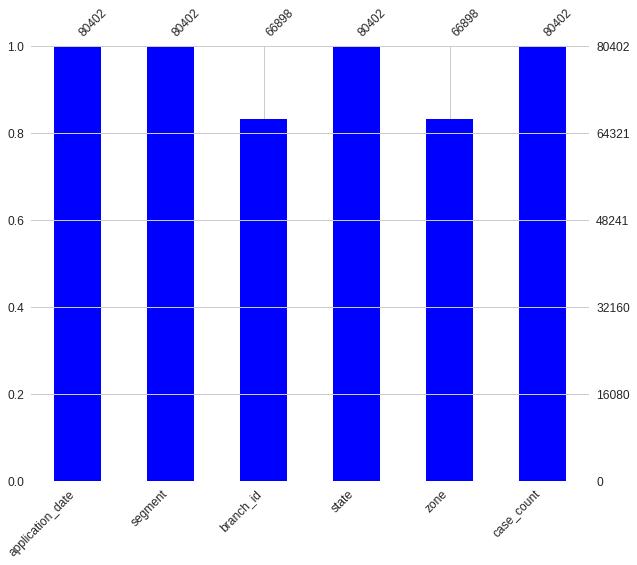

In [5]:
%matplotlib inline

msno.bar(prim_data, figsize=(10,8), fontsize=12, color='blue', inline=True)  # Plot missing values

In [6]:
# Dissect state details, for example branch ids for each state:
states = list(prim_data.state.unique())
for state in states:
    print(f"{state}:: Branch IDs: {prim_data.loc[prim_data.state == state].branch_id.unique()}")

WEST BENGAL:: Branch IDs: [ 1.  7.  8.  9. 10. 11. 29. 42. nan]
DELHI:: Branch IDs: [3.]
KARNATAKA:: Branch IDs: [  5.  64. 121.  nan]
TAMIL NADU:: Branch IDs: [ 13.  35.  43.  69.  76. 136. 260.  nan]
UTTAR PRADESH:: Branch IDs: [ 14. 100. 101. 262. 268. 269. 270.  nan]
PUNJAB:: Branch IDs: [ 15.  62.  72.  73. 264.  nan]
TELANGANA:: Branch IDs: [ 16. 266.]
ANDHRA PRADESH:: Branch IDs: [ 17.  66. 111. 263. 265. 267.]
MAHARASHTRA:: Branch IDs: [ 18.  19.  21.  70.  74.  77.  78.  85. 117. 135. 137. 248. 249.  nan]
ORISSA:: Branch IDs: [ 20.  48. 165.  nan]
GUJARAT:: Branch IDs: [ 34.  61.  67.  68. 105. 207. 250. 257.  nan]
ASSAM:: Branch IDs: [ 36.  65. 254. 255.  nan]
JHARKHAND:: Branch IDs: [ 63. 104.  nan]
UTTARAKHAND:: Branch IDs: [ 79. 202.]
KERALA:: Branch IDs: [82. nan]
CHHATTISGARH:: Branch IDs: [84. nan]
BIHAR:: Branch IDs: [103. 159. 217.  nan]
TRIPURA:: Branch IDs: [120. 251.  nan]
MADHYA PRADESH:: Branch IDs: [147.  nan]
HARYANA:: Branch IDs: [258. 259. 261. 271.  nan]


Several observations from this loop execution:
* Maharashtra has the highest number of branches.
* All state names are in uppercases, so we'll use uppercase nouns wherever legitimate.
* Almost all states except Delhi and Telangana have NaN branches. These also happen to be the states with least number of branches.

In [3]:
# Let's explore some data for individual states

prim_data["application_date"] = pd.to_datetime(prim_data.application_date,
                                               format="%Y-%m-%d").copy()  # Copy to prevent warning
prim_data.set_index("application_date", inplace=True)

In [30]:
karnataka_dat = prim_data.loc[prim_data.state == 'KARNATAKA'].copy()
karnataka_dat["branch_id"].fillna(0, inplace=True)  # Fill missing branch with 0s just for exploration sake

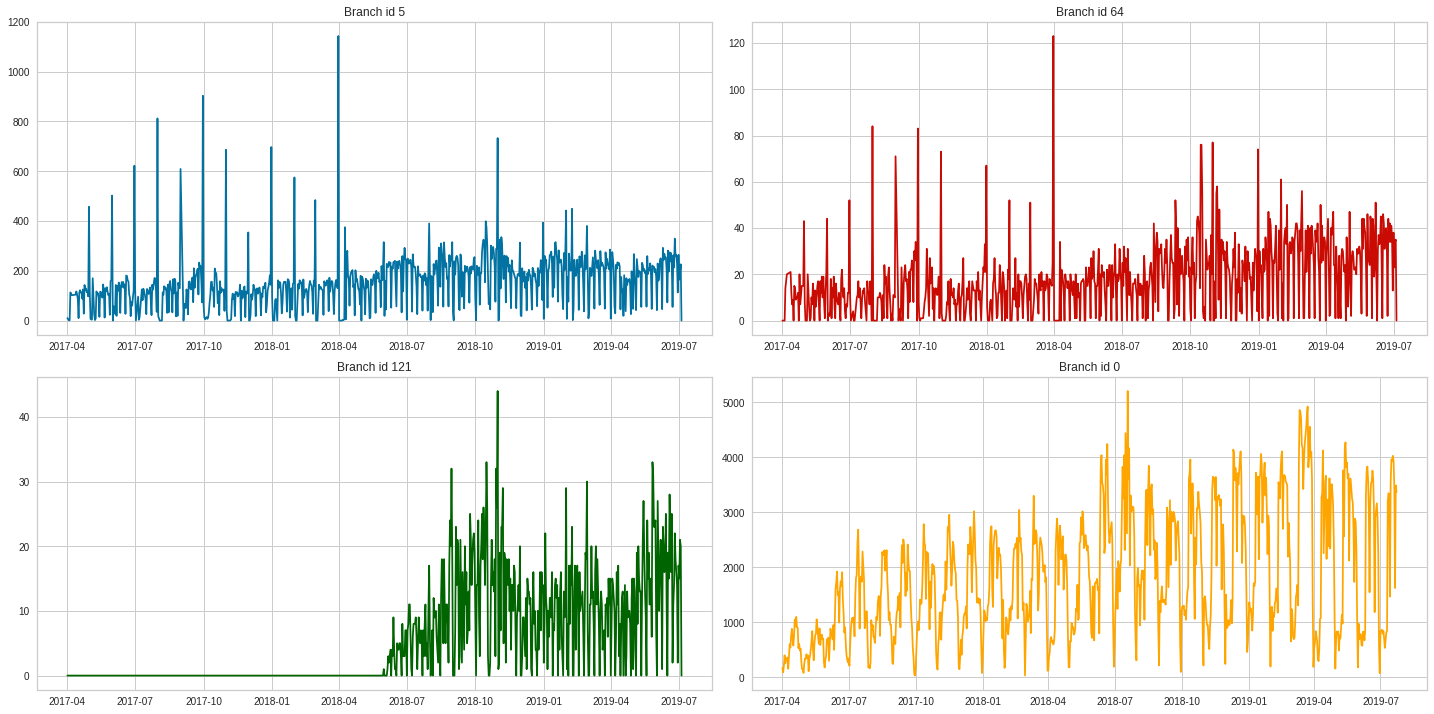

In [33]:
figure, axes = plt.subplots(2, 2, figsize=(20,10))
figure.tight_layout(pad=1)
axes[0][0].plot(karnataka_dat["case_count"].loc[karnataka_dat.branch_id == 5.0])
axes[0][0].set_title("Branch id 5")
axes[0][1].plot((karnataka_dat["case_count"].loc[karnataka_dat.branch_id == 64.0]), color='r')
axes[0][1].set_title("Branch id 64")
axes[1][0].plot((karnataka_dat["case_count"].loc[karnataka_dat.branch_id == 121.0]), color='darkgreen')
axes[1][0].set_title("Branch id 121")
axes[1][1].plot((karnataka_dat["case_count"].loc[karnataka_dat.branch_id == 0.0]), color='orange')
axes[1][1].set_title("Branch id 0")
figure.tight_layout(pad=1)

Text(0.5, 1, 'Branch id 1')

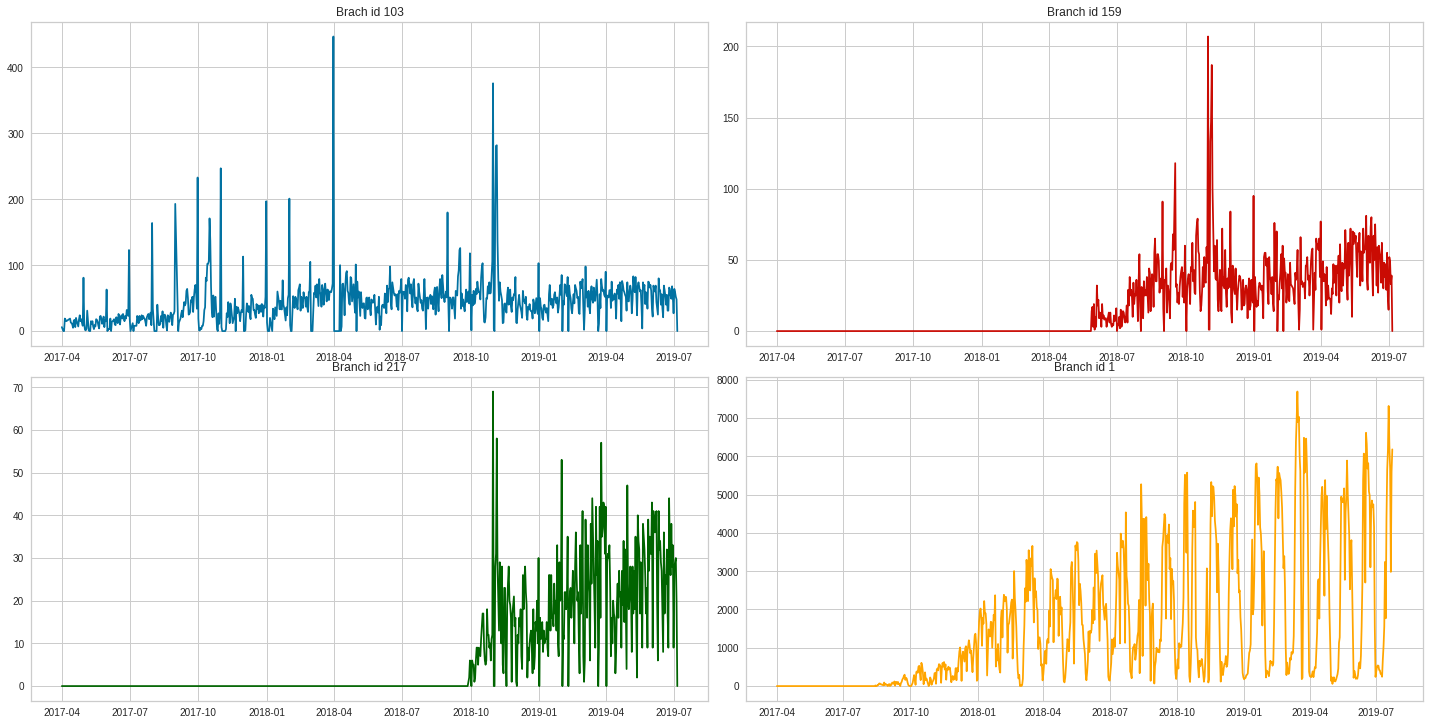

In [36]:
bihar_dat = prim_data.loc[prim_data.state == 'BIHAR'].copy()
bihar_dat["branch_id"].fillna(0, inplace=True)

figure, axes = plt.subplots(2, 2, figsize=(20,10))
figure.tight_layout(pad=1)
axes[0][0].plot((bihar_dat["case_count"].loc[bihar_dat.branch_id == 103.0]))
axes[0][0].set_title("Brach id 103")
axes[0][1].plot((bihar_dat["case_count"].loc[bihar_dat.branch_id == 159.0]), color='r')
axes[0][1].set_title("Branch id 159")
axes[1][0].plot((bihar_dat["case_count"].loc[bihar_dat.branch_id == 217.0]), color='darkgreen')
axes[1][0].set_title("Branch id 217")
axes[1][1].plot((bihar_dat["case_count"].loc[bihar_dat.branch_id == 0]), color='orange')
axes[1][1].set_title("Branch id 1")



Again, many observations from such plots:
1. Some branches seem to be operating from a long period of time. Some of them are new and hence 0 intakes of cases can be explained.
2. The empty values for known branches can also be attributed to missing values. However, that's not the case as we saw above. `case_counts` does not record missing values.
3. The plots for unknown branches has extremely high numbers. This can be the segment-2 which could attribute to micro finance and rural access.

## Preprocessing and Cleaning
This phase will consist of several cleaning stages such as filling the missing values and adding in more data. But first, let's fill the most important thing that I believe is the missing branch IDs for the second segment of the business problem. For filling the NaN branches, I came up with unique numbers that do not overlap with the existing ones. Since we also have missing zones for these branches, let's fill those too. I'll redesign how the zones are defined so as each zone has equal number of states and hence weights during predictions.

In [4]:
# Fill values in primary data
prim_data.loc[(prim_data.state == "WEST BENGAL"), ['zone']] = 'EAST'
prim_data.loc[(prim_data.state == "DELHI"), ['zone']] = 'NORTH'
prim_data.loc[(prim_data.state == "KARNATAKA"), ['zone']] = 'SOUTH'
prim_data.loc[(prim_data.state == "TAMIL NADU"), ['zone']] = 'SOUTH'
prim_data.loc[(prim_data.state == "UTTAR PRADESH"), ['zone']] = 'NORTH'
prim_data.loc[(prim_data.state == "PUNJAB"), ['zone']] = 'NORTH'
prim_data.loc[(prim_data.state == "TELANGANA"), ['zone']] = 'SOUTH'
prim_data.loc[(prim_data.state == "ASSAM"), ['zone']] = 'EAST'
prim_data.loc[(prim_data.state == "ANDHRA PRADESH"), ['zone']] = 'SOUTH'
prim_data.loc[(prim_data.state == "MAHARASHTRA"), ['zone']] = 'WEST'
prim_data.loc[(prim_data.state == "ORISSA") & (prim_data.segment == 2), ['zone']] = 'SOUTH'  # Merge SOUTH zone into EAST
prim_data.loc[(prim_data.state == "GUJARAT"), ['zone']] = 'WEST'
prim_data.loc[(prim_data.state == "ASSAM"), ['zone']] = 'EAST'
prim_data.loc[(prim_data.state == "JHARKHAND"), ['zone']] = 'EAST'
prim_data.loc[(prim_data.state == "UTTARAKHAND"), ['zone']] = 'NORTH'
prim_data.loc[(prim_data.state == "KERALA"), ['zone']] = 'SOUTH'
prim_data.loc[(prim_data.state == "CHHATTISGARH"), ['zone']] = 'CENTRAL'
prim_data.loc[(prim_data.state == "BIHAR"), ['zone']] = 'EAST'
prim_data.loc[(prim_data.state == "TRIPURA"), ['zone']] = 'EAST'
prim_data.loc[(prim_data.state == "MADHYA PRADESH"), ['zone']] = 'CENTRAL'
prim_data.loc[(prim_data.state == "HARYANA"), ['zone']] = 'NORTH'

prim_data.branch_id.fillna(int(0), axis=0, inplace=True)

prim_data.loc[(prim_data.state == "WEST BENGAL") & (prim_data.branch_id == 0.0), ['branch_id']] = 44
prim_data.loc[(prim_data.state == "KARNATAKA") & (prim_data.branch_id == 0.0), ['branch_id']] = 122
prim_data.loc[(prim_data.state == "TAMIL NADU") & (prim_data.branch_id == 0.0), ['branch_id']] = 272
prim_data.loc[(prim_data.state == "UTTAR PRADESH") & (prim_data.branch_id == 0.0), ['branch_id']] = 273
prim_data.loc[(prim_data.state == "PUNJAB") & (prim_data.branch_id == 0.0), ['branch_id']] = 274
prim_data.loc[(prim_data.state == "ASSAM") & (prim_data.branch_id == 0.0), ['branch_id']] = 256
prim_data.loc[(prim_data.state == "MAHARASHTRA") & (prim_data.branch_id == 0.0), ['branch_id']] = 252
prim_data.loc[(prim_data.state == "ORISSA") & (prim_data.branch_id == 0.0), ['branch_id']] = 166
prim_data.loc[(prim_data.state == "GUJARAT") & (prim_data.branch_id == 0.0), ['branch_id']] = 275
prim_data.loc[(prim_data.state == "JHARKHAND") & (prim_data.branch_id == 0.0), ['branch_id']] = 106
prim_data.loc[(prim_data.state == "KERALA") & (prim_data.branch_id == 0.0), ['branch_id']] = 83
prim_data.loc[(prim_data.state == "CHHATTISGARH") & (prim_data.branch_id == 0.0), ['branch_id']] = 86
prim_data.loc[(prim_data.state == "BIHAR") & (prim_data.branch_id == 0.0), ['branch_id']] = 218
prim_data.loc[(prim_data.state == "TRIPURA") & (prim_data.branch_id == 0.0), ['branch_id']] = 252
prim_data.loc[(prim_data.state == "MADHYA PRADESH") & (prim_data.branch_id == 0.0), ['branch_id']] = 148
prim_data.loc[(prim_data.state == "HARYANA") & (prim_data.branch_id == 0.0), ['branch_id']] = 276

In [5]:
# Check if everything's functioning
print(prim_data.zone.unique())
print(prim_data.branch_id.unique())

['EAST' 'NORTH' 'SOUTH' 'WEST' 'CENTRAL']
[  1.   3.   5.   7. ... 274. 272. 273.  44.]


As we can see, all NaNs are filled.

In [8]:
# Dissect primary data on segment
print(prim_data.groupby("segment").case_count.agg(['mean', 'median', 'min', 'max']))

               mean  median  min    max
segment                                
1         32.707106      14    0   1890
2        942.318646     371    0  13787


As you can see, segment 2 has much higher intakes (`case_counts`) indicating that this might be the rural segment that LTFS operates.

In [13]:
prim_data.loc[prim_data.segment == 1].groupby("state")["case_count"].agg(['mean', 'min', 'max', 'std']).sort_values(by="mean")

,mean,min,max,std
state,,,,
ANDHRA PRADESH,3.517370,0,179,8.804760
HARYANA,3.736973,0,118,8.305876
CHHATTISGARH,3.968983,0,66,6.269935
UTTAR PRADESH,4.251152,0,416,15.959437
KERALA,11.795285,0,87,10.399667
PUNJAB,18.079156,0,448,26.755810
TAMIL NADU,22.158632,0,685,39.784219
JHARKHAND,22.158809,0,241,18.998797
BIHAR,22.780397,0,447,30.726861


Interesting insights provided by the above chained command. While Delhi has the least number of branches, it receives on an average the most number of cases folloed by Karnataka, Telangana, West Bengal and Gujarat. Not very surprisingly but somewhat ironic, Maharashtra that has the most number of branches drops at the upper percentile for average case counts. The least case counts are recorded by Andhra Pradesh, Haryana and Chhattisgarh as well as U.P.

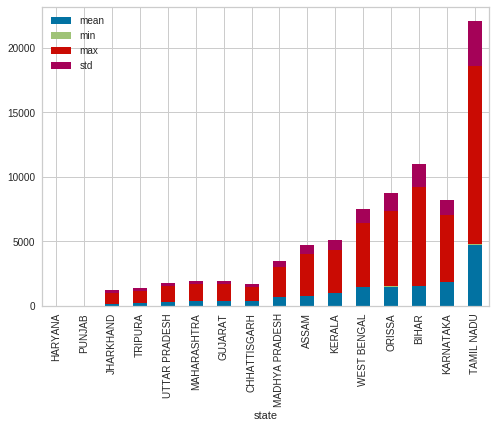

In [20]:
prim_data.loc[prim_data.segment == 2].groupby("state")["case_count"].agg(['mean', 'min', 'max', 'std']).sort_values(by='mean').plot.bar(stacked=True)

Tamil Nadu receives the highest number of cases augmenting to segment II followed by Karnataka and Bihar. Haryana and Punjab record the least number of case counts (these states seem to not have a segment 2 operating).

In [8]:
prim_data.loc[prim_data.segment == 2].groupby("state")["case_count"].agg(["min", "max", "mean", "std"]).sort_values(by="max")

,min,max,mean,std
state,,,,
HARYANA,0,0,0.000000,0.000000
PUNJAB,0,0,0.000000,0.000000
JHARKHAND,0,833,158.571090,205.858336
TRIPURA,0,997,177.534360,209.765988
CHHATTISGARH,0,1111,350.644550,234.114321
UTTAR PRADESH,0,1203,306.938389,227.242140
GUJARAT,0,1308,346.502370,254.263053
MAHARASHTRA,0,1312,340.305687,251.294388
MADHYA PRADESH,0,2350,641.349526,478.639699


As is evident, Tamil Nadu has the highest record for maximum intakes (13787) which for some might seem out of proportion considering that the data records daily intake values.

In [37]:
segment_1 = prim_data.loc[prim_data.segment == 1]
len(segment_1)

66898

In [38]:
segment_1 = pd.DataFrame(segment_1.groupby("application_date")["case_count"].agg("max"))
print(len(segment_1))
print(segment_1.shape)

806
(806, 1)


In [39]:
segment_1.head(10)

,case_count
application_date,
2017-04-01,58
2017-04-03,13
2017-04-04,6
2017-04-05,113
2017-04-07,107
2017-04-12,123
2017-04-13,117
2017-04-14,117
2017-04-15,127


In [18]:
print(type(segment_1)); print("Length: {0}".format(segment_1.shape)); print(segment_1.columns)

<class 'pandas.core.frame.DataFrame'>
Length: (806, 1)
Index(['max'], dtype='object')


In [26]:
# Slice off segment 2
segment_2 = prim_data.loc[prim_data.segment == 2]

In [27]:
segment_2 = pd.DataFrame(segment_2.groupby("application_date")["case_count"].agg("max"))

In [31]:
type(segment_2)
print(segment_2.head())
print(segment_2.columns)

                  case_count
application_date            
2017-04-01               458
2017-04-02               182
2017-04-03              1161
2017-04-04               881
2017-04-05              1142
Index(['case_count'], dtype='object')


In [58]:
# Start adding some features, like year, month and day
def add_dateFeatures(dataset, field_name="application_date"):
    """
    Add date_time features
    """
    from fastai.collab import add_datepart
    # Check if index is date_time
    if str(type(dataset.index)) == "<class 'pandas.core.indexes.datetimes.DatetimeIndex'>":
        dataset.reset_index(inplace=True)
        add_datepart(dataset, dataset[field_name])
    else:
        print("Index needs to be date_time")
    
    return dataset.columns


In [59]:
add_dateFeatures(segment_1)

Index needs to be date_time


Index(['application_date', 'case_count'], dtype='object')

In [3]:
prim_data.groupby(["application_date", "segment"], as_index=False)["case_count"].sum()

,application_date,segment,case_count
0,2017-04-01,1,299
1,2017-04-01,2,897
2,2017-04-02,2,605
3,2017-04-03,1,42
4,2017-04-03,2,2016
...,...,...,...
1645,2019-07-19,2,29778
1646,2019-07-20,2,26123
1647,2019-07-21,2,12267
1648,2019-07-22,2,27292
